### Importing required modules

In [272]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data into dataset

In [269]:

from calibration_dataset import Tell1Dataset

class MyDS(Tell1Dataset):
    filename_format = '%Y-%m-%d'
    filename_regex_format = r'\d{4}-\d{2}-\d{2}.csv'

datapath = "../data/calibrations/"
data_list = MyDS.get_filepaths_from_dir(datapath)
mds = MyDS(data_list, read=True)




100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.12it/s]


### Seperating data

In [199]:
data = {'hit threshold':mds.dfh.df,'pedestal' : mds.dfp.df,'low threshold': mds.dfl.df}

### Clearing data

In [200]:
for key in data:
    data[key] = data[key].drop(['Zmod','slot_label','mod_nr','sensor_number','type','datetime'],axis=1)
    data[key] = {'phi':data[key][(data[key]['mod_type'] =='VELO_phi') & (data[key]['sensor_type'] == 'phi')],\
                    'r_phi':data[key][(data[key]['mod_type'] =='VELO_phi') & (data[key]['sensor_type'] == 'R')],\
                 'r_RX':data[key][(data[key]['mod_type'] =='VELO_Rx')]}
    for typ in data[key]:
        data[key][typ] = data[key][typ].drop(['mod_type','sensor_type'],axis=1)

### Importing modules needed for PCA

In [229]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

### Sets color map for plot, can be changed by editing 
##### cm = plt.get_cmap(new color map)


In [261]:
def set_color(plot):
    num_colors = 30
    cm = plt.get_cmap('jet')
    cNorm  = mpl.colors.Normalize(vmin=0, vmax=num_colors-1)
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cm)
    colors = [scalarMap.to_rgba(i) for i in range(num_colors)]
    random.shuffle(colors,lambda: 0.1)
    plot.set_prop_cycle("color",colors)

### Data normalization and PCA

In [220]:
def full_pca(data,percent):
    data = StandardScaler().fit_transform(data)
    data_transponsed = data.transpose()
    pca = PCA(n_components = percent,svd_solver = 'auto')
    result = pca.fit_transform(data_transponsed)
    column_names = [f"Principal component {x+1}" for x in range(len(result[0]))]
    row_names = [f"Channel {x}" for x in range(len(result))]
    return pd.DataFrame(result,columns = column_names,index = row_names)

### Setting plot size and number of primal components 

In [208]:
plt.rcParams['figure.figsize'] = [16, 9*15]
procentage_or_num_of_comp = 2

### Gets single sensor data, making PCA and scattering it at plot
#### alpha - sets transparency of the points

In [263]:
def scatter_data(single_data): 
    alpha = 0.4
    for sensor_data_key in single_data:
        dataset = single_data[sensor_data_key]
        dataset_after_pca = full_pca(dataset,procentage_or_num_of_comp)
        scatter = plt.scatter(dataset_after_pca.iloc[:,0], dataset_after_pca.iloc[:,1], edgecolor='none', alpha=alpha,label=sensor_data_key)
        plt.legend(title="Module nr.")

### Separating module type data into single module

In [210]:
def draw_a_plot(sensor, mod_key):
    for sensor_key in sensor:
        single_data = sensor[sensor_key]
        plot = plt.subplot(draw_a_plot.position, title=f'{mod_key} - {sensor_key}')
        set_color(plot)
        single_data = {k: v.drop('sensor',axis=1) for k, v in single_data.groupby('sensor')}
        scatter_data(single_data)
        plt.xlabel('Principal component 1')
        plt.ylabel('Principal component 2')
        draw_a_plot.position+=1

### Separates data into modules types data then plotting it

In [211]:
def do_a_pca_and_draw_a_plot(data):
    draw_a_plot.position = 911
    plt.suptitle("PCA results",fontsize=16)
    for mod_key in data:
        draw_a_plot(data[mod_key],mod_key)


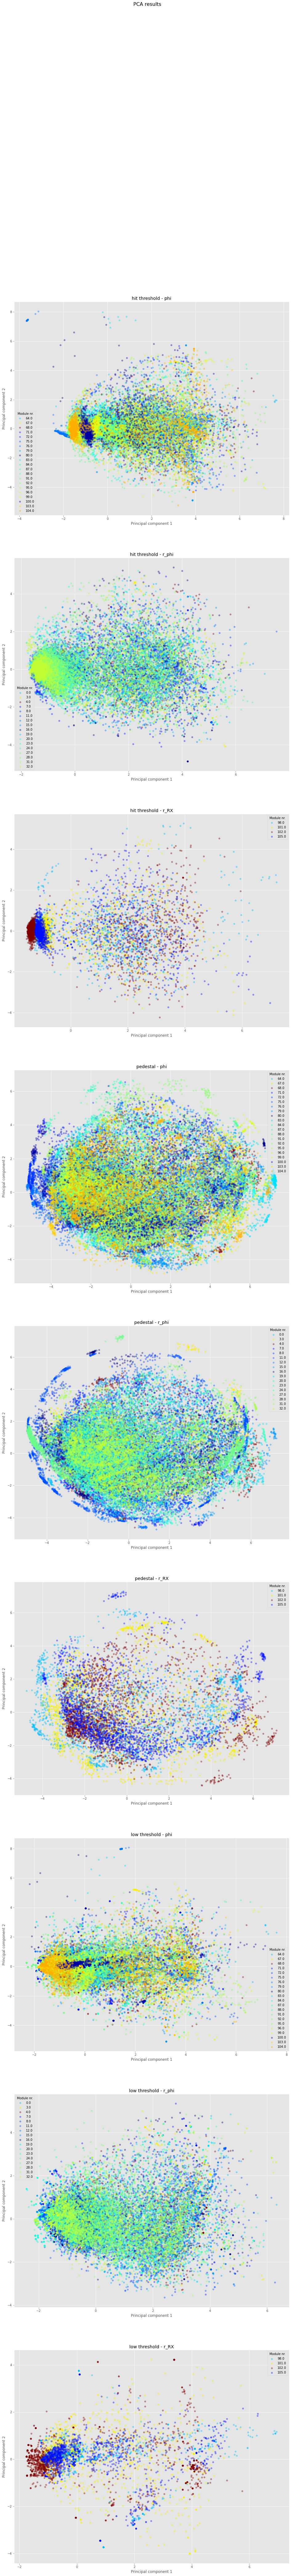

In [276]:
do_a_pca_and_draw_a_plot(data)